In [63]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from utils import make_table, fazer_testes
from time import time

In [64]:
sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

@dataclass
class Item:
    valor: int
    peso: int
    is_otimo: bool

    @property
    def custo_beneficio(self):
        return self.valor / self.peso

BeneficioMaximo, Capacidade = int, int


def get_data(cat: int, size: int) -> tuple[BeneficioMaximo, Capacidade, list[Item]]:
    path = "dataset/{}/knapPI_{}_{}_1000_1"

    with open(path.format("large_scale", cat, size), "r") as f:
        get_line_values = lambda: list(map(int, f.readline().split()))
        # Pega o resultado ótimo
        with open(path.format("large_scale-optimum", cat, size), "r") as g:
            beneficio_maximo = int(g.read())

        # Primeira Linha: número de itens `n`e capacidade da mochila
        n, capacidade = get_line_values()

        # Próximas `n`linhas: valor e peso de cada item
        valores, pesos = [list(i) for i in zip(*[get_line_values() for _ in range(n)])]

        # Última linha: vetor de booleanos indicando quais itens compõe uma solução ótima
        solucoes_otimas = get_line_values()

        itens = [
            Item(v, p, bool(otimo))
            for v, p, otimo in zip(valores, pesos, solucoes_otimas)
        ]

    return beneficio_maximo, capacidade, itens


### Analise do dataset

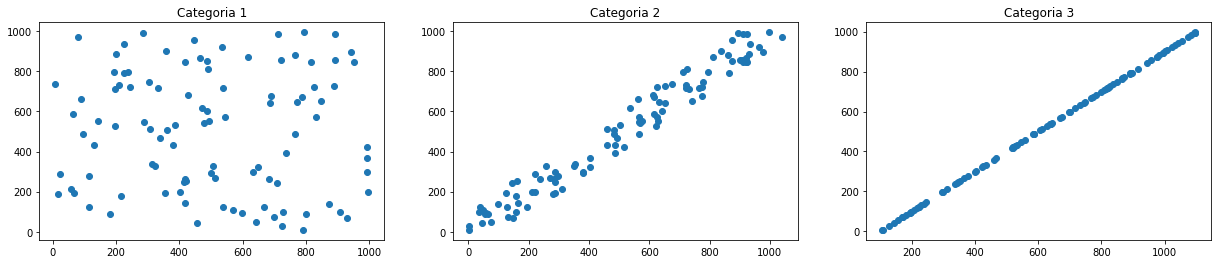

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(21, 4))

for cat in [1, 2, 3]:
    itens = get_data(cat, size=100)[2]

    valores = [i.valor for i in itens]
    pesos = [i.peso for i in itens]

    ax[cat - 1].scatter(valores, pesos)
    ax[cat - 1].set_title(f"Categoria {cat}")


### Abordagem Gulosa

##### Priorizando o número de items a serem inseridos

In [66]:
def perf_aprox_gulosa_max_numero_itens(categoria, size):
    beneficio_maximo, capacidade, itens = get_data(categoria, size)

    v, w = 0, 0

    for item in sorted(itens, key=lambda i: i.peso):
        if (w + item.peso) > capacidade:
            break
        w += item.peso
        v += item.valor

    desempenho = v / beneficio_maximo
    return desempenho

In [44]:
results, times = fazer_testes(perf_aprox_gulosa_max_numero_itens, repeticoes=1)
print("Precisão do algoritmo comparado ao resultado ótimo (%)")
make_table(results)

print("Tempos de execução em segundos")
make_table(times)

Precisão do algoritmo comparado ao resultado ótimo (%)
╒═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│             │   100    │   200    │   500    │   1000   │   2000   │   5000   │  10000   │  Média   │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ Categoria 1 │ 0.950366 │ 0.956042 │ 0.872821 │ 0.871897 │ 0.88367  │ 0.888087 │ 0.878992 │ 0.900268 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Categoria 2 │ 0.569353 │ 0.638311 │ 0.680026 │ 0.679629 │ 0.663232 │ 0.630805 │ 0.654295 │ 0.645093 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Categoria 3 │ 0.990822 │ 0.982202 │ 0.99733  │ 0.998888 │ 0.996819 │ 0.999186 │ 0.999789 │ 0.995005 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Média  

##### Priorizando os itens de melhor relação de benefício/custo

In [67]:
def perf_aprox_gulosa_beneficio_custo(categoria, size):
    beneficio_maximo, capacidade, itens = get_data(categoria, size)

    v, w = 0, 0
    for item in sorted(itens, key=lambda i: i.valor / i.peso, reverse=True):
        if (w + item.peso) < capacidade:
            w += item.peso
            v += item.valor

    desempenho = v / beneficio_maximo
    return desempenho

In [68]:
results, times = fazer_testes(perf_aprox_gulosa_beneficio_custo, repeticoes=1)

print("Precisão do algoritmo comparado ao resultado ótimo (%)")
make_table(results)

print("Tempos de execução em segundos")
make_table(times)


Precisão do algoritmo comparado ao resultado ótimo (%)
╒═════════════╤════════════╤═══════════╤═══════════╤═══════════╕
│             │    2000    │   5000    │   10000   │   Média   │
╞═════════════╪════════════╪═══════════╪═══════════╪═══════════╡
│ Categoria 1 │ 0.00720835 │ 0.0141809 │ 0.0343387 │ 0.018576  │
├─────────────┼────────────┼───────────┼───────────┼───────────┤
│ Categoria 2 │ 0.00748229 │ 0.107033  │ 0.0271766 │ 0.0472308 │
├─────────────┼────────────┼───────────┼───────────┼───────────┤
│ Categoria 3 │ 0.00415468 │ 0.0127158 │ 0.103564  │ 0.0401448 │
├─────────────┼────────────┼───────────┼───────────┼───────────┤
│ Média       │ 0.00628177 │ 0.0446434 │ 0.0550265 │ 0.0353172 │
╘═════════════╧════════════╧═══════════╧═══════════╧═══════════╛
Tempos de execução em segundos
╒═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│             │   100    │   200    │   500    │   1000   │   2000   │   5000   │  10000   │  M

### Abordagem por Programação Dinâmica

In [59]:
def abordagem_prog_dinamica(categoria, size):
    beneficio_maximo, W, itens = get_data(categoria, size)
    # array que guarda os resultados ótimos para mochilas de capacidade indo de 0 a W
    mochilas = [0 for _ in range(W + 1)]

    for item in itens:
        # index do peso das mochilas anteriores que cabem na mochila
        w_validos = [w for w in range(W) if item.peso + w <= W]

        for w in w_validos:
            mochilas[w] = max(mochilas[w], mochilas[w + item.peso] + item.valor)
    return mochilas[0]

In [73]:
from time import time

tempos = []
repeticoes = 1
for size in sizes[:4]:
    tempos_por_size = []
    for _ in range(repeticoes):
        start = time()
        abordagem_prog_dinamica(3, size)
        end = time()

        tempos_por_size.append(end - start)
    
    tempos.append(sum(tempos_por_size)/repeticoes)


